In [16]:
import re
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
from scipy import stats

# ---------------------------
# Parsing
# ---------------------------

def parse_results_file(path: str) -> Dict[str, Dict[str, Dict[str, float]]]:
    """
    Parse one results file.

    Returns:
      data[model][metric] = {'value': float, 'lo': float or None, 'hi': float or None}
    Skips entries with "Not found".
    """
    data: Dict[str, Dict[str, Dict[str, float]]] = {}
    current_model = None

    subject_re = re.compile(r'^\s*Subject:\s*(.+?)\s*$')
    line_re = re.compile(r'^\s{2,}(.+?):\s*(.+?)\s*$')
    num_ci_re = re.compile(
        r'^\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)\s*\[\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)\s*,\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)\s*\]\s*$'
    )
    num_only_re = re.compile(r'^\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)\s*$')

    with open(path, 'r', encoding='utf-8') as f:
        for raw in f:
            line = raw.rstrip('\n')

            m_sub = subject_re.match(line)
            if m_sub:
                current_model = m_sub.group(1).strip()
                if current_model not in data:
                    data[current_model] = {}
                continue

            m_line = line_re.match(line)
            if not m_line or current_model is None:
                continue

            metric = m_line.group(1).strip()
            val_str = m_line.group(2).strip()

            # Skip "Not found"
            if val_str.lower().startswith('not found'):
                continue

            m_num_ci = num_ci_re.match(val_str)
            if m_num_ci:
                v = float(m_num_ci.group(1))
                lo = float(m_num_ci.group(2))
                hi = float(m_num_ci.group(3))
                data[current_model][metric] = {'value': v, 'lo': lo, 'hi': hi}
                continue

            m_num = num_only_re.match(val_str)
            if m_num:
                v = float(m_num.group(1))
                data[current_model][metric] = {'value': v, 'lo': None, 'hi': None}
                continue

            # Unrecognized format; ignore
    return data


# ---------------------------
# Utilities
# ---------------------------

def is_correlation_metric(metric_name: str) -> bool:
    """Heuristic: treat metrics containing 'correl' (case-insensitive) as correlations."""
    return 'correl' in metric_name.lower()

def zcrit_from_level(level: float = 0.95) -> float:
    return stats.norm.ppf(0.5 + level/2.0)

def fisher_z(x: np.ndarray) -> np.ndarray:
    x = np.clip(x, -0.999999, 0.999999)
    return np.arctanh(x)

def inv_fisher_z(z: np.ndarray) -> np.ndarray:
    return np.tanh(z)

def se_from_ci(lo: np.ndarray, hi: np.ndarray, level: float = 0.95) -> np.ndarray:
    zcrit = zcrit_from_level(level)
    return (hi - lo) / (2.0 * zcrit)

def se_from_ci_fisher_r(lo_r: np.ndarray, hi_r: np.ndarray, level: float = 0.95) -> np.ndarray:
    zcrit = zcrit_from_level(level)
    lo_z = fisher_z(lo_r)
    hi_z = fisher_z(hi_r)
    return (hi_z - lo_z) / (2.0 * zcrit)

def fixed_effect_pool(values: np.ndarray, se: np.ndarray) -> Tuple[float, float, float]:
    """Inverse-variance weighted mean and its SE and CI bounds (on the same scale as values)."""
    w = 1.0 / (se**2)
    mu = np.sum(w * values) / np.sum(w)
    se_mu = 1.0 / np.sqrt(np.sum(w))
    return mu, se_mu, w.sum()

def mean_t_ci(x: np.ndarray, level: float = 0.95) -> Tuple[float, float, float]:
    """Mean, SE, and t critical for a sample (across models)."""
    k = x.size
    m = x.mean()
    sd = x.std(ddof=1) if k > 1 else 0.0
    se = sd / np.sqrt(k) if k > 0 else np.nan
    tcrit = stats.t.ppf(0.5 + level/2.0, df=max(k-1, 1))
    return m, se, tcrit


# ---------------------------
# Collect per-metric data
# ---------------------------

def collect_metric_data(metric: str, file_paths: List[str]) -> Dict[str, pd.DataFrame]:
    """
    For each file, return a DataFrame with columns:
      model, value, lo, hi, has_ci (bool)
    Only includes models that have the metric present.
    """
    out = {}
    metric_lower = metric.lower()
    for path in file_paths:
        parsed = parse_results_file(path)
        rows = []
        for model, metrics in parsed.items():
            # case-insensitive lookup across keys
            match_key = None
            for k in metrics.keys():
                if k.lower() == metric_lower:
                    match_key = k
                    break
            if match_key is None:
                continue
            entry = metrics[match_key]
            v = entry.get('value', None)
            lo = entry.get('lo', None)
            hi = entry.get('hi', None)
            if v is None:
                continue
            has_ci = lo is not None and hi is not None
            rows.append({'model': model, 'value': float(v),
                         'lo': float(lo) if has_ci else np.nan,
                         'hi': float(hi) if has_ci else np.nan,
                         'has_ci': has_ci})
        df = pd.DataFrame(rows)
        out[path] = df.sort_values('model').reset_index(drop=True)
    return out


# ---------------------------
# Per-file summaries
# ---------------------------

def summarize_per_file(metric: str,
                       file_to_df: Dict[str, pd.DataFrame],
                       ci_level: float = 0.95) -> pd.DataFrame:
    """
    For each file, compute an overall mean and CI:
      - If per-model CIs exist: fixed-effect inverse-variance pooling.
        * If correlation metric: operate on Fisher z and back-transform for reporting.
        * Else: operate on raw scale.
      - If no per-model CIs: mean±t across models.
    Returns a DataFrame with columns:
      file, n_models, method, mean, ci_lo, ci_hi
    """
    is_corr = is_correlation_metric(metric)
    zcrit = zcrit_from_level(ci_level)

    rows = []
    for path, df in file_to_df.items():
        n = len(df)
        if n == 0:
            rows.append({'file': path, 'n_models': 0, 'method': 'no data',
                         'mean': np.nan, 'ci_lo': np.nan, 'ci_hi': np.nan})
            continue

        has_any_ci = df['has_ci'].any()
        if has_any_ci:
            # Use only models with CIs
            d = df[df['has_ci']].copy()
            if len(d) == 0:
                rows.append({'file': path, 'n_models': 0, 'method': 'no usable CI',
                             'mean': np.nan, 'ci_lo': np.nan, 'ci_hi': np.nan})
                continue

            if is_corr:
                # Pool on Fisher z
                vals_z = fisher_z(d['value'].to_numpy())
                se_z = se_from_ci_fisher_r(d['lo'].to_numpy(), d['hi'].to_numpy(), level=ci_level)
                se_z, used_floor = stabilize_se(se_z, fallback='floor')
                z_bar, se_bar, _ = fixed_effect_pool(vals_z, se_z)
                ci_z = (z_bar - zcrit*se_bar, z_bar + zcrit*se_bar)
                mean_r = float(inv_fisher_z(np.array([z_bar]))[0])
                ci_lo = float(inv_fisher_z(np.array([ci_z[0]]))[0])
                ci_hi = float(inv_fisher_z(np.array([ci_z[1]]))[0])
                method = 'fixed-effect IVW on Fisher z'
                rows.append({'file': path, 'n_models': int(len(d)), 'method': method,
                             'mean': mean_r, 'ci_lo': ci_lo, 'ci_hi': ci_hi})
            else:
                # Pool on raw scale
                vals = d['value'].to_numpy()
                se = se_from_ci(d['lo'].to_numpy(), d['hi'].to_numpy(), level=ci_level)
                se, used_floor = stabilize_se(se, fallback='floor')
                mu, se_mu, _ = fixed_effect_pool(vals, se)
                ci = (mu - zcrit*se_mu, mu + zcrit*se_mu)
                method = 'fixed-effect IVW (raw scale)'
                rows.append({'file': path, 'n_models': int(len(d)), 'method': method,
                             'mean': float(mu), 'ci_lo': float(ci[0]), 'ci_hi': float(ci[1])})
        else:
            # No per-model CIs -> mean±t across models
            vals = df['value'].to_numpy()
            m, se, tcrit = mean_t_ci(vals, level=ci_level)
            ci = (m - tcrit*se, m + tcrit*se) if len(vals) > 1 else (m, m)
            method = 'mean±t across models (no model CIs)'
            rows.append({'file': path, 'n_models': int(len(vals)), 'method': method,
                         'mean': float(m), 'ci_lo': float(ci[0]), 'ci_hi': float(ci[1])})

    summary = pd.DataFrame(rows)
    return summary


# ---------------------------
# Pairwise comparisons
# ---------------------------

def pairwise_comparisons(metric: str,
                         file_to_df: Dict[str, pd.DataFrame],
                         ci_level: float = 0.95,
                         assume_independent: bool = True) -> pd.DataFrame:
    """
    For each file pair:
      - Identify overlapping models with data for the metric in both.
      - If both sides have per-model CIs for the overlaps:
          * If correlation metric: paired IVW difference on Fisher z.
          * Else: paired IVW difference on raw scale.
      - Else (no CIs): paired t-test across models (raw differences).

    Returns DataFrame with:
      file1, file2, n_common, same_model_set, method, est, ci_lo, ci_hi, p_value
    est/CI are on:
      - Fisher z scale for correlation metrics (paired IVW),
      - raw scale otherwise,
      - raw scale difference for paired t.
    """
    is_corr = is_correlation_metric(metric)
    zcrit = zcrit_from_level(ci_level)
    files = list(file_to_df.keys())

    # Precompute model sets for equality check
    models_per_file = {f: set(file_to_df[f]['model']) for f in files}

    records = []

    for i in range(len(files)):
        for j in range(i+1, len(files)):
            f1, f2 = files[i], files[j]
            d1 = file_to_df[f1]
            d2 = file_to_df[f2]
            overlap = sorted(set(d1['model']).intersection(set(d2['model'])))

            same_set = models_per_file[f1] == models_per_file[f2]
            if len(overlap) == 0:
                records.append({'file1': f1, 'file2': f2, 'n_common': 0, 'same_model_set': same_set,
                                'method': 'no overlap', 'est': np.nan, 'ci_lo': np.nan,
                                'ci_hi': np.nan, 'p_value': np.nan})
                continue

            # Join on model
            j1 = d1.set_index('model').loc[overlap]
            j2 = d2.set_index('model').loc[overlap]

            # Identify if we can do IVW (need CIs on both)
            use_ivw = j1['has_ci'].all() and j2['has_ci'].all()

            if use_ivw:
                if is_corr:
                    # Work on Fisher z
                    v1 = fisher_z(j1['value'].to_numpy())
                    v2 = fisher_z(j2['value'].to_numpy())
                    se1 = se_from_ci_fisher_r(j1['lo'].to_numpy(), j1['hi'].to_numpy(), level=ci_level)
                    se2 = se_from_ci_fisher_r(j2['lo'].to_numpy(), j2['hi'].to_numpy(), level=ci_level)
                    # Independence assumption -> Var(d) = se1^2 + se2^2
                    var_d = se1**2 + se2**2 if assume_independent else se1**2 + se2**2
                    d = v2 - v1
                    w = 1.0 / var_d
                    D = np.sum(w * d) / np.sum(w)
                    SE_D = 1.0 / np.sqrt(np.sum(w))
                    ci = (D - zcrit*SE_D, D + zcrit*SE_D)
                    z_stat = D / SE_D
                    p = 2.0 * (1.0 - stats.norm.cdf(abs(z_stat)))
                    method = 'paired IVW on Fisher z'
                    records.append({'file1': f1, 'file2': f2, 'n_common': len(overlap),
                                    'same_model_set': same_set, 'method': method,
                                    'est': float(D), 'ci_lo': float(ci[0]),
                                    'ci_hi': float(ci[1]), 'p_value': float(p)})
                else:
                    # Raw scale IVW
                    v1 = j1['value'].to_numpy()
                    v2 = j2['value'].to_numpy()
                    se1 = se_from_ci(j1['lo'].to_numpy(), j1['hi'].to_numpy(), level=ci_level)
                    se2 = se_from_ci(j2['lo'].to_numpy(), j2['hi'].to_numpy(), level=ci_level)
                    var_d = se1**2 + se2**2 if assume_independent else se1**2 + se2**2
                    d = v2 - v1
                    w = 1.0 / var_d
                    D = np.sum(w * d) / np.sum(w)
                    SE_D = 1.0 / np.sqrt(np.sum(w))
                    ci = (D - zcrit*SE_D, D + zcrit*SE_D)
                    z_stat = D / SE_D
                    p = 2.0 * (1.0 - stats.norm.cdf(abs(z_stat)))
                    method = 'paired IVW (raw scale)'
                    records.append({'file1': f1, 'file2': f2, 'n_common': len(overlap),
                                    'same_model_set': same_set, 'method': method,
                                    'est': float(D), 'ci_lo': float(ci[0]),
                                    'ci_hi': float(ci[1]), 'p_value': float(p)})
            else:
                # Paired t on raw differences across models
                # Use only models with values (ignore CI fields)
                v1 = j1['value'].to_numpy()
                v2 = j2['value'].to_numpy()
                d = v2 - v1
                k = d.size
                Dbar = d.mean()
                sd = d.std(ddof=1) if k > 1 else 0.0
                se = sd / np.sqrt(k) if k > 0 else np.nan
                tcrit = stats.t.ppf(0.5 + ci_level/2.0, df=max(k-1, 1))
                ci = (Dbar - tcrit*se, Dbar + tcrit*se) if k > 1 else (Dbar, Dbar)
                t_stat = Dbar / se if se > 0 else np.inf * np.sign(Dbar)
                p = 2.0 * (1.0 - stats.t.cdf(abs(t_stat), df=max(k-1, 1))) if k > 1 else 0.0
                method = 'paired t across models (no model CIs)'
                records.append({'file1': f1, 'file2': f2, 'n_common': int(k),
                                'same_model_set': same_set, 'method': method,
                                'est': float(Dbar), 'ci_lo': float(ci[0]),
                                'ci_hi': float(ci[1]), 'p_value': float(p)})

    return pd.DataFrame.from_records(records)


# ---------------------------
# Main entry point
# ---------------------------

def analyze_metric_across_files(metric_name: str,
                                file_paths: List[str],
                                ci_level: float = 0.95,
                                assume_independent: bool = True):
    """
    High-level function:
      - Parses files
      - Builds per-file summaries
      - Builds pairwise comparison table

    Returns (summary_df, pairwise_df)
    Also prints both tables.
    """
    file_to_df = collect_metric_data(metric_name, file_paths)

    # Per-file summaries
    summary = summarize_per_file(metric_name, file_to_df, ci_level=ci_level)

    # Pairwise comparisons
    pairwise = pairwise_comparisons(metric_name, file_to_df,
                                    ci_level=ci_level,
                                    assume_independent=assume_independent)

    # Pretty print
    pd.set_option('display.max_colwidth', 120)
    print(f"\nMetric: {metric_name}")
    print("\nPer-file summaries:")
    display(summary)

    print("\nPairwise comparisons:")
    display(pairwise)

    return summary, pairwise

def difference_of_pooled_test(summary_df: pd.DataFrame, ci_level: float = 0.95) -> pd.DataFrame:
    """
    For each file pair in a summary table (from summarize_per_file), test the
    difference between pooled means using their pooled SEs.

    Returns: file1, file2, est, ci_lo, ci_hi, p_value
    """
    zcrit = zcrit_from_level(ci_level)
    rows = []
    for i in range(len(summary_df)):
        for j in range(i+1, len(summary_df)):
            a = summary_df.iloc[i]
            b = summary_df.iloc[j]
            m1, m2 = float(a['mean']), float(b['mean'])
            se1 = (float(a['ci_hi']) - m1) / zcrit
            se2 = (float(b['ci_hi']) - m2) / zcrit
            diff = m1 - m2
            se = np.sqrt(se1**2 + se2**2)
            ci = (diff - zcrit*se, diff + zcrit*se)
            z_stat = diff / se if se > 0 else np.inf * np.sign(diff)
            p = 2.0 * (1.0 - stats.norm.cdf(abs(z_stat)))
            rows.append({'file1': a['file'], 'file2': b['file'],
                         'est': diff, 'ci_lo': ci[0], 'ci_hi': ci[1], 'p_value': p})
    return pd.DataFrame(rows)

def stabilize_se(se: np.ndarray, fallback: str = 'floor') -> Tuple[np.ndarray, bool]:
    """
    Replace nonpositive or nonfinite SEs.
    fallback:
      - 'floor': set to 0.5 * min positive SE (or 1e-12 if none).
      - 'drop': return SEs and a flag indicating there were bad SEs (caller can drop rows).
    Returns (se_fixed, used_floor)
    """
    se = np.asarray(se, float)
    pos = np.isfinite(se) & (se > 0)
    if pos.any():
        floor = max(1e-12, 0.5 * float(np.min(se[pos])))
        bad = ~pos
        if fallback == 'floor':
            se[bad] = floor
            return se, True if bad.any() else False
        elif fallback == 'drop':
            return se, bad.any()
    else:
        # No positive SEs at all
        if fallback == 'floor':
            se[:] = 1e-12
            return se, True
        elif fallback == 'drop':
            return se, True
    return se, False

In [21]:
files = ["analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt"]

# Metrics you listed
metrics = [
    "Delegation rate",
    "Naive Confidence",
    "Teammate-weighted confidence",
    "Raw introspection score",
    "Raw self-acc lift",
    "Correctness Coef Cntl",
    "Pseudo R2 Cntl",                # no CIs -> paired t
    "Capent Correl Cntl",            # treated as correlation (Fisher z)
    "Capent Correl Prob Cntl",       # treated as correlation (Fisher z)
    "Calibration AUC",
    "ECE",
    "Brier",
    "Brier Resolution",
    "Brier Reliability",
    "Top Prob Mean",
]

for m in metrics:
    summarize, compare = analyze_metric_across_files(m, files, ci_level=0.95, assume_independent=True)


Metric: Delegation rate

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,15,mean±t across models (no model CIs),0.384207,0.244362,0.524051
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,15,mean±t across models (no model CIs),0.552193,0.395156,0.709231
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,mean±t across models (no model CIs),0.519300,0.349546,0.689054
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,mean±t across models (no model CIs),0.701520,0.560575,0.842465



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,15,True,paired t across models (no model CIs),0.167987,0.038295,0.297678,0.014804
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,True,paired t across models (no model CIs),0.135093,-0.009075,0.279262,0.064134
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired t across models (no model CIs),0.317313,0.171594,0.463033,0.000361
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,True,paired t across models (no model CIs),-0.032893,-0.222219,0.156432,0.715002
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired t across models (no model CIs),0.149327,-0.013973,0.312626,0.070050
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired t across models (no model CIs),0.182220,0.046372,0.318068,0.012185



Metric: Naive Confidence

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,15,mean±t across models (no model CIs),0.152900,0.000478,0.305322
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,15,mean±t across models (no model CIs),-0.037253,-0.196705,0.122198
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,mean±t across models (no model CIs),0.281540,0.135319,0.427761
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,mean±t across models (no model CIs),0.065087,-0.063874,0.194047



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,15,True,paired t across models (no model CIs),-0.190153,-0.315784,-0.064522,0.005855
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,True,paired t across models (no model CIs),0.128640,-0.034131,0.291411,0.112183
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired t across models (no model CIs),-0.087813,-0.241330,0.065703,0.240114
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,True,paired t across models (no model CIs),0.318793,0.119224,0.518363,0.004095
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired t across models (no model CIs),0.102340,-0.071641,0.276321,0.227701
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired t across models (no model CIs),-0.216453,-0.337512,-0.095394,0.001821



Metric: Teammate-weighted confidence

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,15,fixed-effect IVW (raw scale),0.050924,0.043519,0.058329
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,15,fixed-effect IVW (raw scale),-0.049260,-0.057221,-0.041299
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,fixed-effect IVW (raw scale),0.118860,0.111613,0.126106
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,fixed-effect IVW (raw scale),0.017965,0.010831,0.025099



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),-0.139364,-0.150768,-0.127960,0.0
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),0.078710,0.068039,0.089381,0.0
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),-0.058672,-0.069512,-0.047831,0.0
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),0.191977,0.180899,0.203054,0.0
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),0.073190,0.062242,0.084139,0.0
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),-0.125530,-0.136011,-0.115048,0.0



Metric: Raw introspection score

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,15,fixed-effect IVW (raw scale),0.130885,0.106539,0.155231
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,15,fixed-effect IVW (raw scale),0.103908,0.080447,0.127368
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,fixed-effect IVW (raw scale),0.141092,0.117037,0.165148
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,fixed-effect IVW (raw scale),0.144308,0.117596,0.171020



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),-0.029313,-0.063249,0.004622,0.090450
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),0.015235,-0.019553,0.050024,0.390709
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),0.017392,-0.019354,0.054137,0.353591
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),0.038349,0.004176,0.072521,0.027844
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),0.044254,0.008179,0.080329,0.016202
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),0.002080,-0.034259,0.038419,0.910677



Metric: Raw self-acc lift

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,15,fixed-effect IVW (raw scale),0.106005,0.076924,0.135087
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,15,fixed-effect IVW (raw scale),0.059782,0.026587,0.092978
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,fixed-effect IVW (raw scale),0.022227,0.003565,0.040889
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,fixed-effect IVW (raw scale),0.056633,0.031857,0.081410



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),-0.036931,-0.082694,0.008832,0.113721
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),-0.072294,-0.108737,-0.035852,0.000101
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),-0.028114,-0.071076,0.014848,0.199636
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),-0.033802,-0.075166,0.007561,0.109223
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),0.009137,-0.039472,0.057745,0.712569
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),0.043966,0.010727,0.077205,0.009528



Metric: Correctness Coef Cntl

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,15,fixed-effect IVW (raw scale),1.879967,1.373909,2.386026
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,15,fixed-effect IVW (raw scale),2.064486,1.558425,2.570548
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,fixed-effect IVW (raw scale),2.511758,2.005695,3.017821
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,fixed-effect IVW (raw scale),2.803849,2.297790,3.309909



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),0.184517,-0.531160,0.900194,0.613333
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),0.631797,-0.083881,1.347475,0.083586
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),0.923878,0.208202,1.639553,0.011401
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),0.447280,-0.268400,1.162960,0.220604
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),0.739363,0.023686,1.455041,0.042885
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired IVW (raw scale),0.292076,-0.423602,1.007755,0.423779



Metric: Pseudo R2 Cntl

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,15,mean±t across models (no model CIs),0.089953,0.071505,0.108402
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,15,mean±t across models (no model CIs),0.107373,0.057252,0.157494
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,mean±t across models (no model CIs),0.103260,0.067920,0.138600
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,mean±t across models (no model CIs),0.128573,0.076690,0.180457



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,15,True,paired t across models (no model CIs),0.017420,-0.027711,0.062551,0.421635
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,True,paired t across models (no model CIs),0.013307,-0.034510,0.061123,0.560127
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired t across models (no model CIs),0.038620,-0.009509,0.086749,0.107259
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,15,True,paired t across models (no model CIs),-0.004113,-0.068516,0.060290,0.892993
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired t across models (no model CIs),0.021200,-0.024461,0.066861,0.336243
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,15,True,paired t across models (no model CIs),0.025313,-0.038781,0.089408,0.411208



Metric: Capent Correl Cntl

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,8,fixed-effect IVW on Fisher z,0.198383,0.164198,0.232092
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,8,fixed-effect IVW on Fisher z,0.214195,0.182312,0.245627
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,fixed-effect IVW on Fisher z,0.115257,0.071213,0.158852
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,fixed-effect IVW on Fisher z,0.016945,-0.025716,0.059544



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,8,True,paired IVW on Fisher z,0.015699,-0.032794,0.064191,5.257421e-01
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,False,paired IVW on Fisher z,-0.087384,-0.146327,-0.028440,3.665124e-03
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,False,paired IVW on Fisher z,-0.191464,-0.250965,-0.131964,2.847129e-10
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,False,paired IVW on Fisher z,-0.094580,-0.152006,-0.037154,1.246378e-03
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,False,paired IVW on Fisher z,-0.224116,-0.281931,-0.166301,3.019807e-14
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,True,paired IVW on Fisher z,-0.103821,-0.169220,-0.038421,1.861886e-03



Metric: Capent Correl Prob Cntl

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,7,fixed-effect IVW on Fisher z,0.211812,0.175433,0.247613
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,7,fixed-effect IVW on Fisher z,0.235805,0.201991,0.269057
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,6,fixed-effect IVW on Fisher z,0.150006,0.101762,0.197546
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,6,fixed-effect IVW on Fisher z,0.031396,-0.015821,0.078473



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,7,True,paired IVW on Fisher z,0.024045,-0.027829,0.075918,3.636166e-01
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,6,False,paired IVW on Fisher z,-0.061252,-0.125767,0.003264,6.276978e-02
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,6,False,paired IVW on Fisher z,-0.216153,-0.281784,-0.150521,1.082374e-10
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,6,False,paired IVW on Fisher z,-0.098731,-0.161599,-0.035864,2.083554e-03
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,6,False,paired IVW on Fisher z,-0.259652,-0.323436,-0.195868,1.554312e-15
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,6,True,paired IVW on Fisher z,-0.124912,-0.198213,-0.051611,8.378216e-04



Metric: Calibration AUC

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,9,fixed-effect IVW (raw scale),0.645787,0.627454,0.664120
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,9,fixed-effect IVW (raw scale),0.625355,0.608520,0.642189
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,fixed-effect IVW (raw scale),0.581051,0.555419,0.606683
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,fixed-effect IVW (raw scale),0.707129,0.685002,0.729257



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,9,True,paired IVW (raw scale),-0.017232,-0.042156,0.007693,1.754045e-01
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),-0.065233,-0.099510,-0.030957,1.914135e-04
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),0.045431,0.014351,0.076510,4.170081e-03
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),-0.041357,-0.074424,-0.008291,1.423031e-02
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),0.068692,0.038698,0.098685,7.166608e-06
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,True,paired IVW (raw scale),0.106097,0.071729,0.140465,1.442722e-09



Metric: ECE

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,9,fixed-effect IVW (raw scale),0.394882,0.379328,0.410436
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,9,fixed-effect IVW (raw scale),0.358630,0.344113,0.373147
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,fixed-effect IVW (raw scale),0.721127,0.706924,0.735329
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,fixed-effect IVW (raw scale),0.659258,0.645227,0.673289



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,9,True,paired IVW (raw scale),-0.037486,-0.058792,-0.016180,5.640606e-04
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),0.310505,0.287667,0.333343,0.000000e+00
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),0.235596,0.212613,0.258579,0.000000e+00
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),0.340007,0.317714,0.362300,0.000000e+00
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),0.260987,0.238544,0.283429,0.000000e+00
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,True,paired IVW (raw scale),-0.070410,-0.090486,-0.050333,6.255219e-12



Metric: Brier

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,9,fixed-effect IVW (raw scale),0.396711,0.384261,0.409160
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,9,fixed-effect IVW (raw scale),0.357797,0.346858,0.368735
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,fixed-effect IVW (raw scale),0.671209,0.658332,0.684086
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,fixed-effect IVW (raw scale),0.597663,0.584791,0.610534



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,9,True,paired IVW (raw scale),-0.027807,-0.044438,-0.011177,1.048466e-03
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),0.260027,0.240396,0.279658,0.000000e+00
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),0.176380,0.156556,0.196204,0.000000e+00
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),0.282900,0.264285,0.301516,0.000000e+00
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),0.193210,0.174269,0.212151,0.000000e+00
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,True,paired IVW (raw scale),-0.075708,-0.094102,-0.057315,6.661338e-16



Metric: Brier Resolution

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,9,fixed-effect IVW (raw scale),0.009677,0.006981,0.012373
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,9,fixed-effect IVW (raw scale),0.003468,0.001804,0.005131
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,fixed-effect IVW (raw scale),0.001262,0.000345,0.002180
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,fixed-effect IVW (raw scale),0.004079,0.002416,0.005743



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,9,True,paired IVW (raw scale),-0.002136,-0.005717,0.001445,2.422965e-01
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),-0.008417,-0.011774,-0.005061,8.863750e-07
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),-0.005258,-0.009089,-0.001428,7.136993e-03
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),-0.002631,-0.004901,-0.000361,2.312196e-02
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),0.000360,-0.002372,0.003091,7.962818e-01
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,True,paired IVW (raw scale),0.002791,0.000716,0.004865,8.385076e-03



Metric: Brier Reliability

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,9,fixed-effect IVW (raw scale),0.155726,0.143034,0.168418
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,9,fixed-effect IVW (raw scale),0.092881,0.083734,0.102027
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,fixed-effect IVW (raw scale),0.513273,0.492655,0.533890
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,fixed-effect IVW (raw scale),0.422416,0.404017,0.440816



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,9,True,paired IVW (raw scale),-0.033547,-0.049677,-0.017416,4.578712e-05
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),0.329792,0.304015,0.355570,0.000000e+00
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),0.231614,0.207114,0.256113,0.000000e+00
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),0.357457,0.332861,0.382053,0.000000e+00
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),0.254911,0.231695,0.278128,0.000000e+00
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,True,paired IVW (raw scale),-0.096935,-0.124730,-0.069140,8.182788e-12



Metric: Top Prob Mean

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,9,fixed-effect IVW (raw scale),0.853919,0.847715,0.860124
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,9,fixed-effect IVW (raw scale),0.999389,0.999093,0.999684
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,fixed-effect IVW (raw scale),0.924073,0.922081,0.926065
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,fixed-effect IVW (raw scale),0.920373,0.916514,0.924231



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,9,True,paired IVW (raw scale),0.009705,0.001416,0.017995,2.174501e-02
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),0.050720,0.042171,0.059269,0.000000e+00
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),0.045115,0.035708,0.054521,0.000000e+00
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),-0.017742,-0.021622,-0.013861,0.000000e+00
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,False,paired IVW (raw scale),0.023150,0.015609,0.030690,1.773845e-09
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,7,True,paired IVW (raw scale),0.004840,0.000423,0.009257,3.175715e-02


In [12]:
difference_of_pooled_test(summarize)

,file1,file2,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,-0.184519,-0.900196,0.531158,0.613329
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,-0.631790,-1.347469,0.083888,0.083589
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,-0.923882,-1.639558,-0.208206,0.011401
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,-0.447271,-1.162951,0.268408,0.220613
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,-0.739363,-1.455040,-0.023685,0.042885
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,-0.292091,-1.007770,0.423587,0.423755


In [43]:
import os
from typing import List, Optional, Dict, Tuple
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt

# Assumes parse_results_file(path) is already defined and returns:
# data[model][metric] = {'value': float, 'lo': float|None, 'hi': float|None}

def plot_metric_bars(
    metric: str,
    files: List[str],
    series_names: Optional[List[str]] = None,
    model_order: Optional[List[str]] = None,
    aliases: Optional[Dict[str, str]] = None,
    title: Optional[str] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    outfile: Optional[str] = None,
    figsize: Tuple[int, int] = (12, 6),
    dpi: int = 150,
    show_errorbars: bool = True,
    capsize: float = 3.0,
    ecolor: Optional[str] = None,  # None = matplotlib default
    elinewidth: float = 1.0,
    alpha_err: float = 0.7,
    chance: Optional[float] = None,
) -> Tuple[plt.Figure, plt.Axes, pd.DataFrame]:
    """
    Grouped bar chart for a metric across results files parsed by parse_results_file.

    - X-axis: models
    - Bars: one per file (series), ordered as in `files`
    - Optional:
        - series_names: legend labels (must match len(files))
        - model_order: explicit model order; others appended
        - aliases: {original_model_name: alias} for tick labels
        - title/xlabel/ylabel/outfile: labels and save path
        - show_errorbars: plot asymmetric CI if available (lo/hi)
    Returns:
        fig, ax, wide_values (DataFrame indexed by model, columns=series)
    """
    if not files:
        raise ValueError("files must be non-empty")
    if series_names is None:
        series_names = [os.path.basename(f) for f in files]
    if len(series_names) != len(files):
        raise ValueError("series_names length must match files")

    # Parse with your exact parser
    per_file = []
    all_models = set()
    for f in files:
        d = parse_results_file(f)
        per_file.append((f, d))
        all_models.update(d.keys())

    # Determine model ordering
    if model_order:
        models = [m for m in model_order if m in all_models] + [m for m in sorted(all_models) if m not in model_order]
    else:
        models = sorted(all_models)

    # Helper to pick metric (exact, then case-insensitive)
    def get_metric_entry(model_metrics: Dict[str, Dict[str, float]], name: str):
        if name in model_metrics:
            return model_metrics[name]
        lower_map = {k.lower(): k for k in model_metrics.keys()}
        k = lower_map.get(name.lower())
        return model_metrics.get(k, None) if k else None

    # Build wide tables: value, lo, hi
    wide_val = pd.DataFrame(index=models, columns=series_names, dtype=float)
    wide_lo  = pd.DataFrame(index=models, columns=series_names, dtype=float)
    wide_hi  = pd.DataFrame(index=models, columns=series_names, dtype=float)

    for (f, data), label in zip(per_file, series_names):
        for m in models:
            v = lo = hi = np.nan
            if m in data:
                entry = get_metric_entry(data[m], metric)
                if entry is not None:
                    v = entry.get("value", np.nan)
                    lo = entry.get("lo", np.nan)
                    hi = entry.get("hi", np.nan)
            wide_val.loc[m, label] = v
            wide_lo.loc[m, label] = lo
            wide_hi.loc[m, label] = hi

    # Drop models with no data for this metric across all series
    keep = wide_val.notna().any(axis=1) #wide_val.notna().all(axis=1)
    wide_val = wide_val.loc[keep]
    wide_lo  = wide_lo.loc[keep]
    wide_hi  = wide_hi.loc[keep]
    models = list(wide_val.index)  # keep order in the filtered table

    # Plot grouped bars
    n_models = len(models)
    n_series = len(series_names)
    x = np.arange(n_models)
    width = min(0.8 / max(n_series, 1), 0.22)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    for i, col in enumerate(series_names):
        vals = wide_val[col].to_numpy(dtype=float)
        pos = x - (n_series - 1) * width / 2 + i * width

        kwargs = {}
        if show_errorbars:
            lo = wide_lo[col].to_numpy(dtype=float)
            hi = wide_hi[col].to_numpy(dtype=float)

            # Compute asymmetric error lengths; mask where missing/invalid
            lower = vals - lo
            upper = hi - vals

            # Invalid if any NaN or negative (guard against rounding issues)
            invalid = np.isnan(lower) | np.isnan(upper) | (lower < 0) | (upper < 0)
            lower = np.where(invalid, np.nan, lower)
            upper = np.where(invalid, np.nan, upper)

            yerr = np.vstack([lower, upper])
            yerr = ma.array(yerr, mask=np.isnan(yerr))

            if (~yerr.mask).any():
                kwargs.update(dict(
                    yerr=yerr,
                    capsize=capsize,
                    error_kw=dict(elinewidth=elinewidth, alpha=alpha_err, ecolor=ecolor),
                ))
            # else: no valid errorbars in this series; skip

        ax.bar(pos, vals, width, label=col, **kwargs)

    # X tick labels (aliases)
    xlabels = [aliases.get(m, m) for m in models] if aliases else models
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=45, ha="right")

    ax.set_xlabel(xlabel or "Model")
    ax.set_ylabel(ylabel or metric)
    if title:
        ax.set_title(title)
    ax.legend(title="Series")
    ax.grid(axis="y", linestyle=":", alpha=0.35)
    if chance is not None:
        ax.axhline(chance, linestyle="--", color="0.4", linewidth=1.2, zorder=0)
    fig.tight_layout()

    # Save and show
    if outfile is None:
        safe_metric = "".join(ch if ch.isalnum() or ch in ("_", "-") else "_" for ch in metric)
        outfile = f"{safe_metric}_bars.png"
    fig.savefig(outfile, bbox_inches="tight")
    plt.show()

    return fig, ax, wide_val

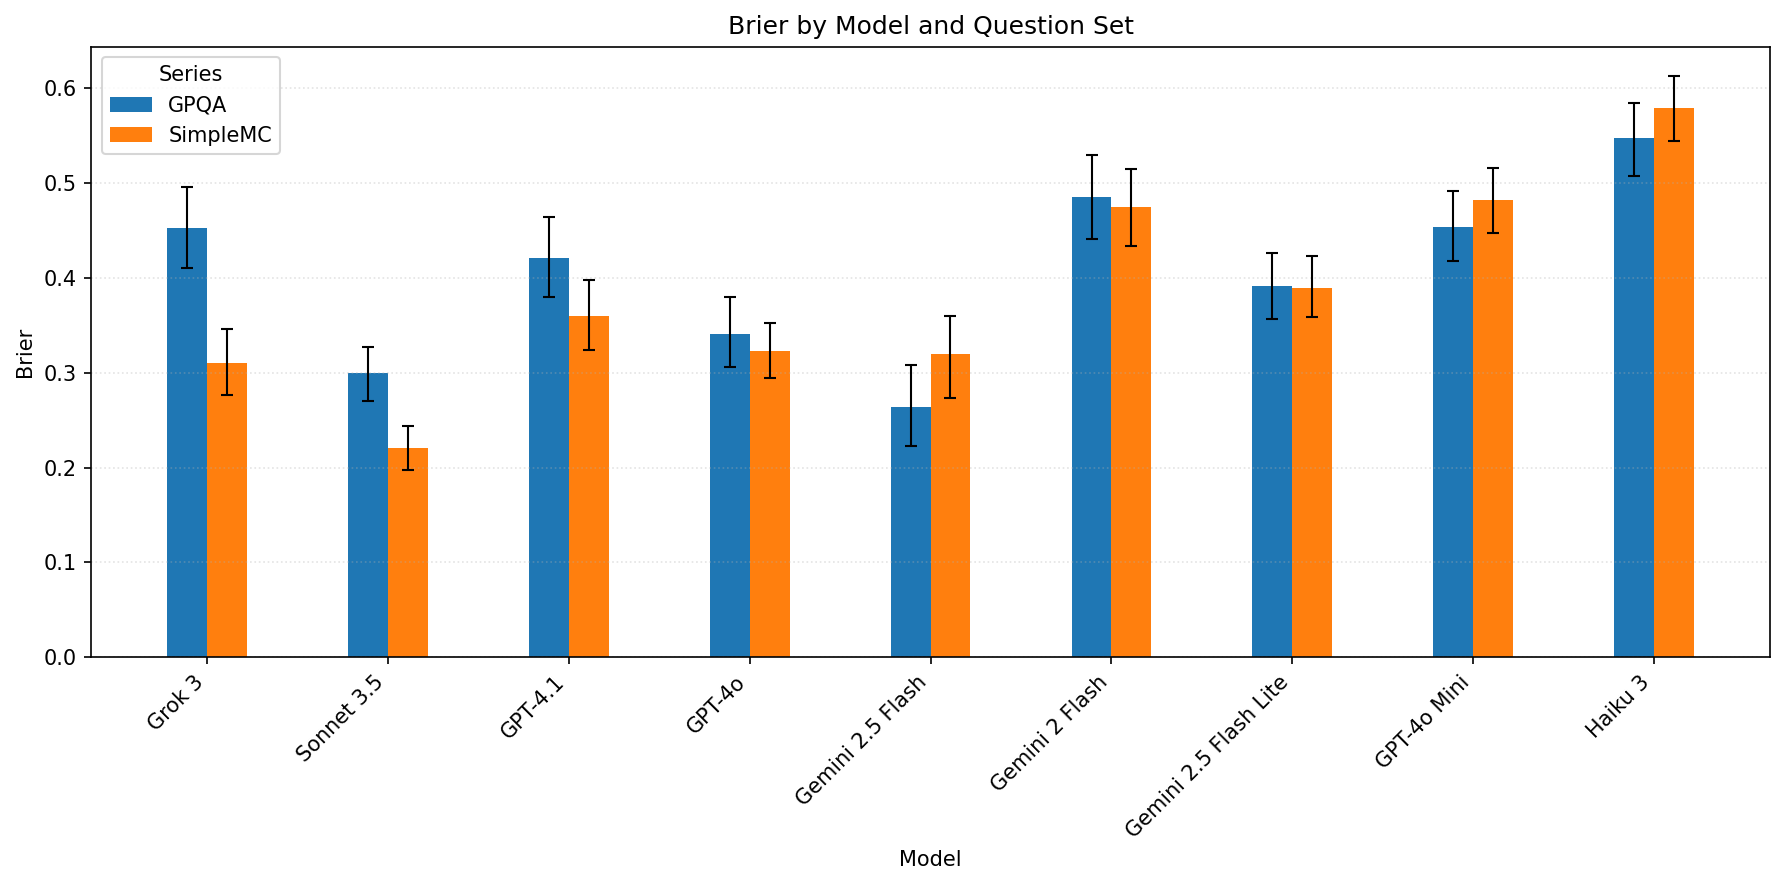

In [47]:
files = ["analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt"]#, "analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt"]

metrics = [
    "Delegation rate",
    "Naive Confidence",
    "Teammate-weighted confidence",
    "Raw introspection score",
    "Raw self-acc lift",
    "Correctness Coef Cntl",
    "Pseudo R2 Cntl",                # no CIs -> paired t
    "Capent Correl Cntl",            # treated as correlation (Fisher z)
    "Capent Correl Prob Cntl",       # treated as correlation (Fisher z)
    "Calibration AUC",
    "Calibration Entropy AUC",
    "ECE",
    "Brier",
    "Brier Resolution",
    "Brier Reliability",
    "Top Prob Mean",
]
chance = None#0.5
model_order=["openai-gpt-5-chat", "claude-opus-4-1-20250805", 'claude-sonnet-4-20250514', 'grok-3-latest', 'claude-3-5-sonnet-20241022', 'gpt-4.1-2025-04-14', 'gpt-4o-2024-08-06', 'deepseek-chat', "gemini-2.5-flash", 'gemini-2.0-flash-001', "gemini-2.5-flash-lite", 'gpt-4o-mini', 'claude-3-sonnet-20240229', 'claude-3-haiku-20240307', 'gemini-1.5-pro']

model_aliases = {
    "openai-gpt-5-chat": "GPT-5",
    "claude-opus-4-1-20250805": "Opus 4.1",
    'claude-sonnet-4-20250514': "Sonnet 4",
    'grok-3-latest': "Grok 3",
    'claude-3-5-sonnet-20241022': "Sonnet 3.5",
    'gpt-4.1-2025-04-14': "GPT-4.1",
    'gpt-4o-2024-08-06': "GPT-4o",
    'deepseek-chat': "DeepSeek Chat",
    "gemini-2.5-flash": "Gemini 2.5 Flash",
    'gemini-2.0-flash-001': "Gemini 2 Flash",
    "gemini-2.5-flash-lite": "Gemini 2.5 Flash Lite",
    'gpt-4o-mini': "GPT-4o Mini",
    'claude-3-sonnet-20240229': "Sonnet 3",
    'claude-3-haiku-20240307': "Haiku 3",
    'gemini-1.5-pro': "Gemini 1.5 Pro",
}
fig, ax, df_wide = plot_metric_bars(
    metric="Brier",
    files=files,
    series_names=["GPQA", "SimpleMC"],#, "GPSA", "SimpleQA"],
    model_order=model_order,
    aliases=model_aliases,
    title="Brier by Model and Question Set",
    ylabel="",
    outfile="brier_by_model.png"
    , ecolor="black", alpha_err=1.0, chance=chance
)

In [ ]:
import os
from typing import List, Optional, Dict, Tuple
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt

# Assumes parse_results_file(path) exists in scope

def plot_metric_panels_from_results(
    metric: str,
    files: List[str],
    series_names: Optional[List[str]] = None,  # panel titles
    model_order: Optional[List[str]] = None,
    aliases: Optional[Dict[str, str]] = None,
    suptitle: Optional[str] = None,
    outfile: Optional[str] = None,
    dpi: int = 150,
    # Error bars
    show_errorbars: bool = True,
    ecolor: str = "gray",
    alpha_err: float = 1.0,
    elinewidth: float = 1.0,
    capsize: float = 3.0,
    # Panel behavior
    chance: Optional[float] = None,
    sharey: bool = True,
    consistent_models: bool = False,  # if True, only keep models present in ALL files
    bar_color: Optional[str] = None,  # uniform color for bars; None -> default cycle
    annotate: bool = True,            # write values inside bars
    value_fmt: str = "{:.2f}",        # format for values
    label_color: str = "black",
    label_fontsize: int = 5,
    metric_label=None,            # y-axis label (default: metric name)
) -> Tuple[plt.Figure, np.ndarray, List[pd.DataFrame]]:
    """
    Plot each results file in its own panel (2 files -> 1x2, 4 files -> 2x2).
    Uses parse_results_file exactly as-is.
    Returns (fig, axes_flat, list_of_value_dfs).
    """
    n = len(files)
    if n not in (2, 4):
        raise ValueError("This helper expects 2 or 4 files.")
    if series_names is None:
        series_names = [os.path.basename(f) for f in files]
    if len(series_names) != n:
        raise ValueError("series_names length must match files length")

    # Parse all files
    parsed = [parse_results_file(f) for f in files]

    # Collect model sets
    model_sets = [set(d.keys()) for d in parsed]
    if model_order:
        base_models = [m for m in model_order if all((not consistent_models) or (m in s) for s in model_sets)]
        if not consistent_models:
            # include additional models from any file (but model_order first)
            union_rest = sorted(set().union(*model_sets) - set(base_models))
            base_models = base_models + union_rest
    else:
        base_models = sorted(set.intersection(*model_sets)) if consistent_models else sorted(set().union(*model_sets))

    # Layout
    if n == 2:
        nrows, ncols = 1, 2
        figsize = (12, 4.8)
    else:  # n == 4
        nrows, ncols = 2, 2
        figsize = (12, 9)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=dpi, sharey=sharey)
    axes = np.array(axes).reshape(-1)  # flatten

    wide_vals_list: List[pd.DataFrame] = []
    all_ylim_candidates = []

    # Helper: find metric entry with case-insensitive fallback
    def get_entry(mm: Dict[str, Dict[str, float]], name: str):
        if name in mm:
            return mm[name]
        lm = {k.lower(): k for k in mm}
        k = lm.get(name.lower())
        return mm.get(k) if k else None

    for ax, f, title, data in zip(axes, files, series_names, parsed):
        # Build per-panel table
        models_panel = []
        vals = []
        lo_list = []
        hi_list = []

        # Respect base_models ordering; skip models missing this metric
        for m in base_models:
            entry = get_entry(data.get(m, {}), metric)
            if entry is None or entry.get("value") is None:
                continue
            v = entry.get("value", np.nan)
            lo = entry.get("lo", np.nan)
            hi = entry.get("hi", np.nan)
            models_panel.append(m)
            vals.append(v)
            lo_list.append(lo)
            hi_list.append(hi)

        # If nothing to plot, leave empty panel with a note
        if not models_panel:
            ax.text(0.5, 0.5, "No data for this metric", ha="center", va="center", fontsize=10, alpha=0.7)
            ax.set_title(title)
            ax.set_xlabel("Model")
            ax.set_ylabel(metric_label or metric)
            ax.grid(axis="y", linestyle=":", alpha=0.35)
            continue

        # DataFrame for this panel (for return/debug)
        wide = pd.DataFrame(
            {"value": vals, "lo": lo_list, "hi": hi_list},
            index=models_panel,
        )
        wide_vals_list.append(wide)

        # X/ticks
        x = np.arange(len(models_panel))
        width = 0.6
        ticklabels = [aliases.get(m, m) for m in models_panel] if aliases else models_panel

        # Error bars
        kwargs = {}
        if show_errorbars:
            v = np.asarray(vals, dtype=float)
            lo = np.asarray(lo_list, dtype=float)
            hi = np.asarray(hi_list, dtype=float)
            lower = v - lo
            upper = hi - v
            invalid = np.isnan(lower) | np.isnan(upper) | (lower < 0) | (upper < 0)
            lower = np.where(invalid, np.nan, lower)
            upper = np.where(invalid, np.nan, upper)
            yerr = ma.array(np.vstack([lower, upper]), mask=np.isnan(np.vstack([lower, upper])))
            if (~yerr.mask).any():
                kwargs.update(dict(
                    yerr=yerr, capsize=capsize,
                    error_kw=dict(elinewidth=elinewidth, alpha=alpha_err, ecolor=ecolor),
                ))

            # Collect y-limit candidates (values and CIs)
            valid_min = np.nanmin(np.where(np.isnan(lo), v, lo))
            valid_max = np.nanmax(np.where(np.isnan(hi), v, hi))
            all_ylim_candidates.append(valid_min)
            all_ylim_candidates.append(valid_max)
        else:
            all_ylim_candidates.extend([np.nanmin(vals), np.nanmax(vals)])

        # Bars
        #ax.bar(x, vals, width, **kwargs)
        bar_kwargs = dict(**kwargs)
        if bar_color is not None:
            bar_kwargs["color"] = bar_color
        bars = ax.bar(x, vals, width, **bar_kwargs)
        if annotate:
            for rect, v in zip(bars, vals):
                if np.isnan(v):
                    continue
                va = "top" if v >= 0 else "bottom"
                dy = -3 if v >= 0 else 3  # points offset
                ax.annotate(
                    value_fmt.format(v),
                    xy=(rect.get_x() + rect.get_width() / 2, v),
                    xytext=(0, dy),
                    textcoords="offset points",
                    ha="center",
                    va=va,
                    fontsize=label_fontsize,
                    color=label_color,
                    clip_on=True,
                )

        # Chance line (optional)
        if chance is not None:
            ax.axhline(chance, linestyle="--", color="0.4", linewidth=1.2, zorder=0)

        # Labels
        ax.set_xticks(x)
        ax.set_xticklabels(ticklabels, rotation=45, ha="right")
        ax.set_title(title)
        ax.set_xlabel("Model")
        ax.set_ylabel(metric_label or metric)
        ax.grid(axis="y", linestyle=":", alpha=0.35)

    # Match y-limits across panels if sharing or if chance line suggests it
    if sharey and len(all_ylim_candidates) > 0:
        ymin = np.nanmin(all_ylim_candidates)
        ymax = np.nanmax(all_ylim_candidates)
        if chance is not None:
            ymin = np.nanmin([ymin, chance])
            ymax = np.nanmax([ymax, chance])
        if np.isfinite(ymin) and np.isfinite(ymax) and ymin != ymax:
            # Add small margin
            pad = 0.04 * (ymax - ymin)
            for ax in axes:
                ax.set_ylim(ymin - pad, ymax + pad)

    if suptitle:
        fig.suptitle(suptitle, y=0.98)

    fig.tight_layout(rect=(0, 0, 1, 0.97))

    if outfile is None:
        safe_metric = "".join(ch if ch.isalnum() or ch in ("_", "-") else "_" for ch in metric)
        outfile = f"{safe_metric}_panels.png"
    fig.savefig(outfile, bbox_inches="tight")
    plt.show()

    return fig, axes, wide_vals_list

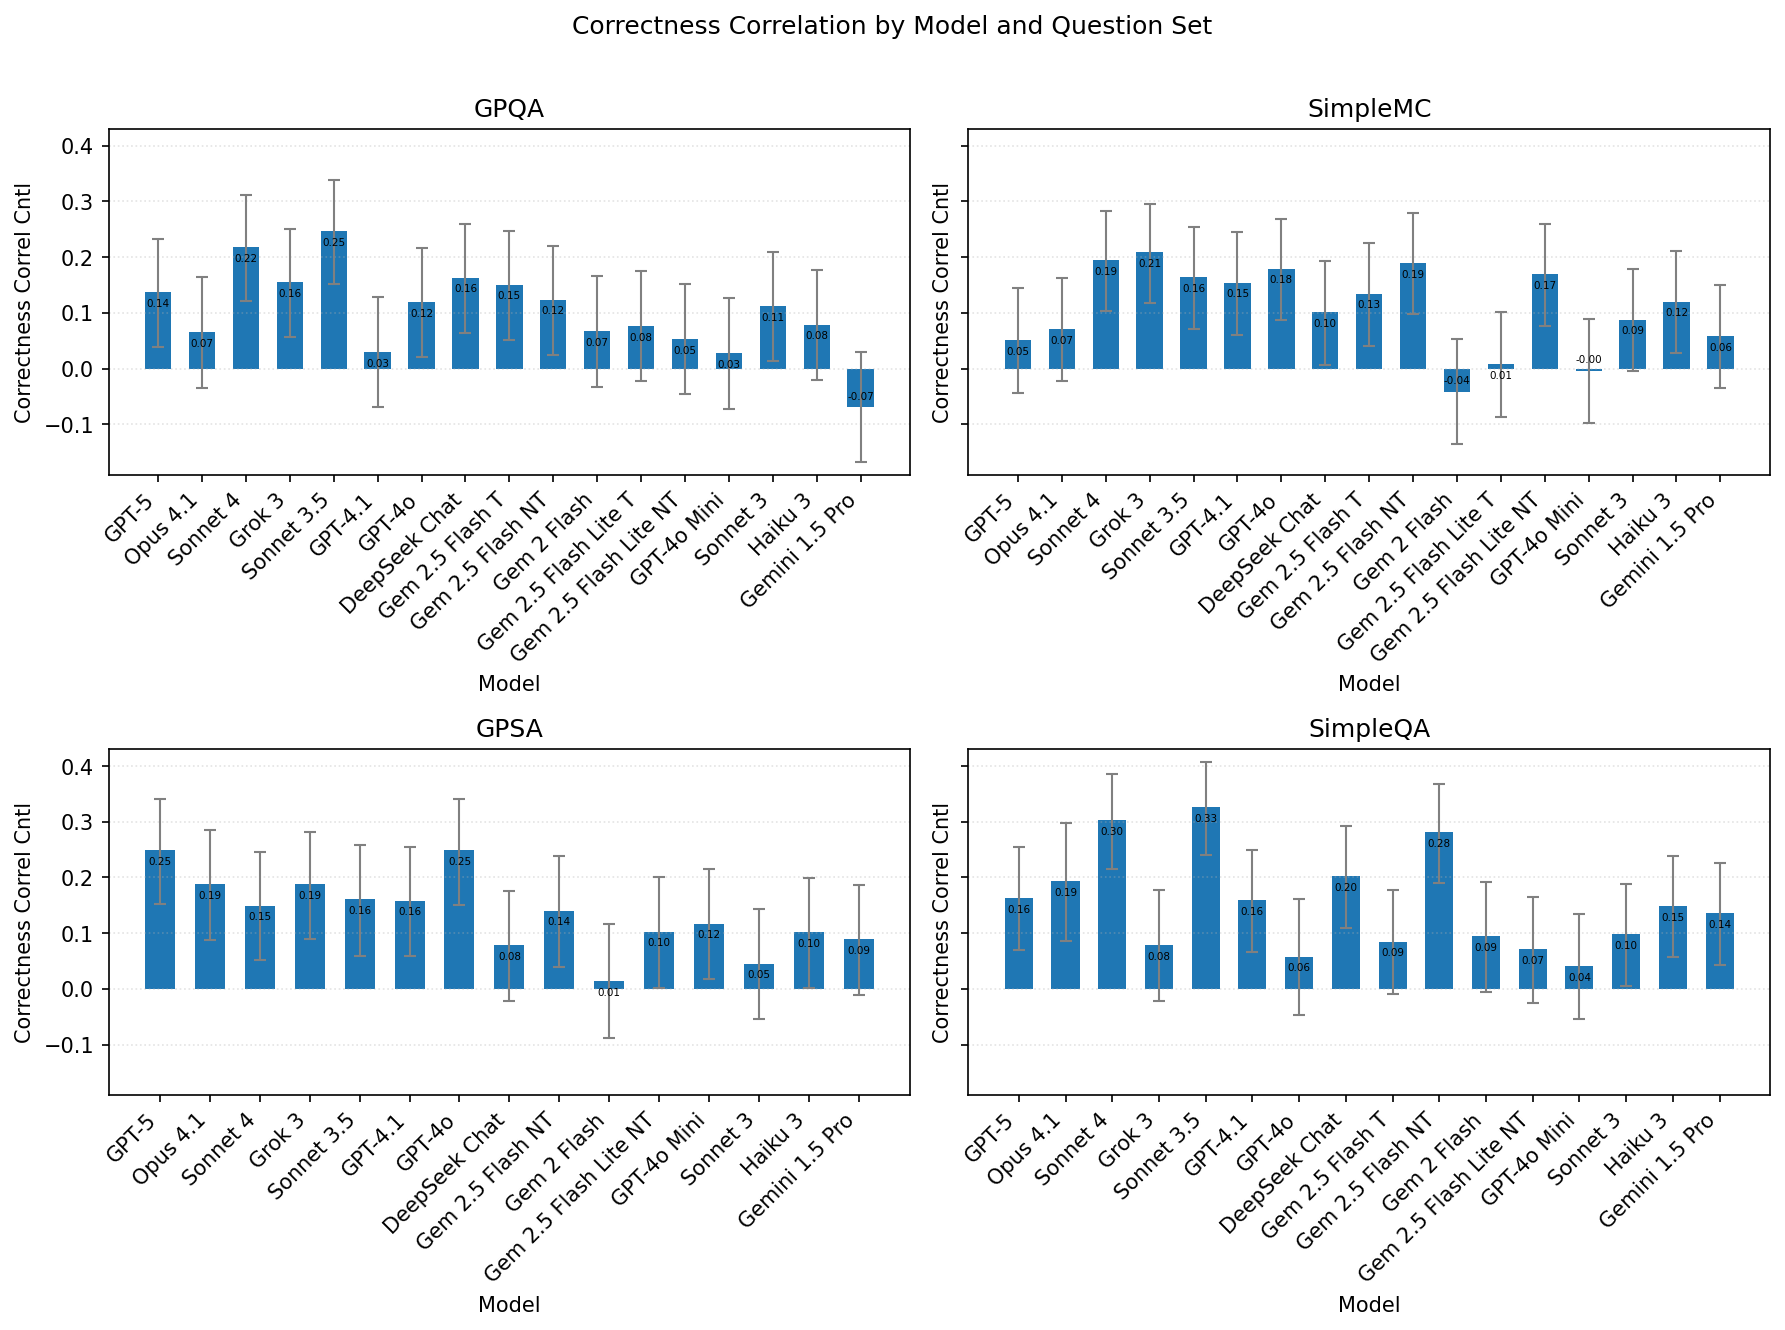

In [79]:
files = ["analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt"]

metrics = [
    "Delegation rate",
    "Naive Confidence",
    "Teammate-weighted confidence",
    "Raw introspection score",
    "Raw self-acc lift",
    "Correctness Coef Cntl",
    "Pseudo R2 Cntl",                # no CIs -> paired t
    "Capent Correl Cntl",            # treated as correlation (Fisher z)
    "Capent Correl Prob Cntl",       # treated as correlation (Fisher z)
    "Calibration AUC",
    "Calibration Entropy AUC",
    "ECE",
    "Brier",
    "Brier Resolution",
    "Brier Reliability",
    "Top Prob Mean",
]
chance = None#0.5
model_order=["openai-gpt-5-chat", "claude-opus-4-1-20250805", 'claude-sonnet-4-20250514', 'grok-3-latest', 'claude-3-5-sonnet-20241022', 'gpt-4.1-2025-04-14', 'gpt-4o-2024-08-06', 'deepseek-chat', "gemini-2.5-flash_think", "gemini-2.5-flash_nothink", 'gemini-2.0-flash-001', "gemini-2.5-flash-lite_think", "gemini-2.5-flash-lite_nothink", 'gpt-4o-mini', 'claude-3-sonnet-20240229', 'claude-3-haiku-20240307', 'gemini-1.5-pro']

model_aliases = {
    "openai-gpt-5-chat": "GPT-5",
    "claude-opus-4-1-20250805": "Opus 4.1",
    'claude-sonnet-4-20250514': "Sonnet 4",
    'grok-3-latest': "Grok 3",
    'claude-3-5-sonnet-20241022': "Sonnet 3.5",
    'gpt-4.1-2025-04-14': "GPT-4.1",
    'gpt-4o-2024-08-06': "GPT-4o",
    'deepseek-chat': "DeepSeek Chat",
    "gemini-2.5-flash_think": "Gem 2.5 Flash T",
    "gemini-2.5-flash_nothink": "Gem 2.5 Flash NT",
    'gemini-2.0-flash-001': "Gem 2 Flash",
    "gemini-2.5-flash-lite_think": "Gem 2.5 Flash Lite T",
    "gemini-2.5-flash-lite_nothink": "Gem 2.5 Flash Lite NT",
    'gpt-4o-mini': "GPT-4o Mini",
    'claude-3-sonnet-20240229': "Sonnet 3",
    'claude-3-haiku-20240307': "Haiku 3",
    'gemini-1.5-pro': "Gemini 1.5 Pro",
}
fig, ax, df_wide = plot_metric_panels_from_results(
    metric="Correctness Correl Cntl",
    files=files,
    series_names=["GPQA", "SimpleMC", "GPSA", "SimpleQA"],
    model_order=model_order,
    aliases=model_aliases,
    suptitle="Correctness Correlation by Model and Question Set",
    outfile="is_pc_by_model.png"
    , ecolor="gray", alpha_err=1.0, chance=chance, metric_label="Partial correlation"
)

